# Cuda
- Cuda 13 is not supported.  
- Cuda 12.6 is the current supported version
    - I installed the windows exe version of the tools, that might not be necessary as it seems the wheel install below also installs it? maybe?
    - https://pytorch.org/
    - https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html#pip-wheels
    - https://stackoverflow.com/questions/78024121/cannot-convince-pytorch-to-install-with-cuda-windows-11

- **must use a .venv**
- must uninstall non-cuda torch versions
    - pip uninstall torch torchvision
- must use the following syntax
    - pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126

Inside the .venv
- python3 -m pip install --upgrade setuptools pip wheel
- pip install nvidia-pyindex
- pip install nvidia-cuda-runtime-cu12  (Optional?  This might be optional?)
- pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126
- reboot


In [32]:
import torch
torch.cuda.is_available()

True

In [33]:
torch.cuda.get_arch_list()

['sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90']

In [34]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer  # Import to fix NameError
import re
import pandas as pd
from sklearn.metrics import accuracy_score
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib
import time
import datetime

In [35]:
# Download required NLTK resources
nltk.download('punkt')        # General tokenizer (for compatibility)
nltk.download('punkt_tab')    # Specific English tokenizer (fixes LookupError)
nltk.download('stopwords')    # Stop words for filtering common words
nltk.download('wordnet')      # Lemmatizer resource

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\khaai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\khaai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khaai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\khaai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [38]:
train = pd.read_csv('train.csv')
validation = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')

In [39]:
## from google.colab import drive
## drive.mount('/content/drive')

In [40]:
train.shape, validation.shape, test.shape

((17877, 5), (3831, 5), (3831, 5))

In [41]:
import re

def preprocess_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return []

    # Keep only letters and whitespaces
    pattern = f"[a-zA-Z\s]"
    text = ''.join(re.findall(pattern, text))

    # Convert to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = nltk.word_tokenize(text)
#     tokens = ' '.join(tokens)

    return tokens

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\khaai\AppData\Local\Temp\ipykernel_22808\599956801.py:9: SyntaxWarning: invalid escape sequence '\s'
  pattern = f"[a-zA-Z\s]"


In [42]:
#apply the preprocess text to
train['user_review'] = train['user_review'].apply(preprocess_text)
validation['user_review'] = validation['user_review'].apply(preprocess_text)
test['user_review'] = test['user_review'].apply(preprocess_text)

In [43]:
train.head()

,review_id,title,year,user_review,user_suggestion
0,460,Black Squad,2018.0,"[early, access, reviewvery, great, shooter, th...",1
1,2166,Tree of Savior (English Ver.),2016.0,"[i, love, love, love, playing, this, gamesuper...",1
2,17242,Eternal Card Game,2016.0,"[early, access, reviewas, a, fan, of, mtg, and...",1
3,6959,Tactical Monsters Rumble Arena,2018.0,"[turn, based, strategy, game, similiar, to, ff...",1
4,8807,Yu-Gi-Oh! Duel Links,2017.0,"[this, game, has, an, insanely, huge, download...",0


In [44]:
def build_vocabulary(reviews):
    vocab = {}
    index = 1  # Start indexing from 1; reserve 0 for padding
    for review in reviews:
        for word in review:
            if word not in vocab:
                vocab[word] = index
                index += 1
    return vocab

In [45]:
# Concatenate all reviews to build the vocabulary
all_reviews = train['user_review'].tolist() + validation['user_review'].tolist() + test['user_review'].tolist()
vocab = build_vocabulary(all_reviews)
print("Vocabulary Length:", len(vocab))
first_50 = list(vocab.items())[:50]
for key, value in first_50:
    print(f'{key}: {value}')

Vocabulary Length: 104326
early: 1
access: 2
reviewvery: 3
great: 4
shooter: 5
that: 6
have: 7
originality: 8
in: 9
it: 10
but: 11
of: 12
course: 13
some: 14
newbies: 15
dont: 16
understand: 17
mechanic: 18
shooting: 19
which: 20
guns: 21
is: 22
same: 23
or: 24
not: 25
throught: 26
visual: 27
look: 28
and: 29
what: 30
to: 31
do: 32
rankedbut: 33
theres: 34
thing: 35
keeps: 36
me: 37
think: 38
how: 39
would: 40
game: 41
evolve: 42
sure: 43
its: 44
still: 45
i: 46
developers: 47
need: 48
speed: 49
up: 50


In [46]:
#Indexing reviews based on the vocabulary
def index_and_pad_reviews(reviews, vocab, max_length=100):
    """Index and pad tokenized reviews to a fixed length."""
    indexed_reviews = []
    for review in reviews:
        indexed_review = [vocab.get(word, 0) for word in review]  # Use vocab.get to handle unknown words
        # Truncate if review length exceeds max_length
        truncated_review = indexed_review[:max_length]
        # Pad review with zeros if it's shorter than max_length
        padded_review = truncated_review + [0] * (max_length - len(truncated_review))
        indexed_reviews.append(padded_review)
    return indexed_reviews

In [47]:
#converting dataframe to list
train_review = train['user_review'].tolist()
test_review = test['user_review'].tolist()
validation_review = validation['user_review'].tolist()

In [48]:
# Index and pad reviews for each set
train_indexed = index_and_pad_reviews(train_review, vocab)
test_indexed = index_and_pad_reviews(test_review, vocab)
validation_indexed = index_and_pad_reviews(validation_review, vocab)

In [49]:
# Convert indexed reviews back to DataFrame for further use
train['user_review_indexed'] = train_indexed
test['user_review_indexed'] = test_indexed
validation['user_review_indexed'] = validation_indexed

In [50]:
train.head()

,review_id,title,year,user_review,user_suggestion,user_review_indexed
0,460,Black Squad,2018.0,"[early, access, reviewvery, great, shooter, th...",1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,2166,Tree of Savior (English Ver.),2016.0,"[i, love, love, love, playing, this, gamesuper...",1,"[46, 84, 84, 84, 85, 57, 86, 10, 58, 82, 87, 1..."
2,17242,Eternal Card Game,2016.0,"[early, access, reviewas, a, fan, of, mtg, and...",1,"[1, 2, 102, 82, 103, 12, 104, 29, 105, 57, 58,..."
3,6959,Tactical Monsters Rumble Arena,2018.0,"[turn, based, strategy, game, similiar, to, ff...",1,"[126, 127, 128, 41, 129, 31, 130, 131, 132, 9,..."
4,8807,Yu-Gi-Oh! Duel Links,2017.0,"[this, game, has, an, insanely, huge, download...",0,"[57, 41, 58, 159, 160, 161, 71, 81, 162, 82, 1..."


In [51]:
for i in range(3):
    print(train.user_review[i], '\n')

['early', 'access', 'reviewvery', 'great', 'shooter', 'that', 'have', 'originality', 'in', 'it', 'but', 'of', 'course', 'some', 'newbies', 'dont', 'understand', 'mechanic', 'of', 'shooting', 'which', 'guns', 'is', 'same', 'or', 'not', 'throught', 'visual', 'look', 'and', 'what', 'to', 'do', 'in', 'rankedbut', 'theres', 'thing', 'that', 'keeps', 'me', 'think', 'how', 'would', 'game', 'evolve', 'sure', 'its', 'still', 'in', 'early', 'access', 'but', 'i', 'think', 'developers', 'need', 'to', 'speed', 'up', 'process', 'of', 'finishing', 'game', 'cuz', 'still', 'comparing', 'to', 'other', 'games', 'this', 'game', 'has', 'low', 'number', 'of', 'community', 'and', 'some', 'things', 'that', 'makes', 'player', 'think', 'that', 'black', 'squad', 'is', 'another', 'copy', 'of', 'csgo', 'and', 'he', 'would', 'not', 'download', 'iti', 'hope', 'you', 'understand', 'my', 'message', 'i', 'really', 'like', 'this', 'game', 'but', 'i', 'dont', 'think', 'it', 'can', 'keep', 'me', 'for', 'a', 'year'] 

['i'

In [52]:
for i in range(3):
    print(train_indexed[:3][i], '\n')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 12, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 9, 33, 34, 35, 6, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 9, 1, 2, 11, 46, 38, 47, 48, 31, 49, 50, 51, 12, 52, 41, 53, 45, 54, 31, 55, 56, 57, 41, 58, 59, 60, 12, 61, 29, 14, 62, 6, 63, 64, 38, 6, 65, 66, 22, 67, 68, 12, 69, 29, 70, 40, 25, 71, 72, 73, 74, 17] 

[46, 84, 84, 84, 85, 57, 86, 10, 58, 82, 87, 12, 88, 31, 89, 90, 74, 91, 25, 92, 93, 94, 95, 96, 29, 97, 98, 99, 22, 100, 101, 84, 31, 57, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

[1, 2, 102, 82, 103, 12, 104, 29, 105, 57, 58, 106, 82, 107, 41, 100, 108, 109, 97, 110, 111, 29, 112, 113, 114, 115, 116, 117, 82, 118, 119, 120, 9, 121, 74, 122, 123, 10, 124, 125, 4, 41, 81, 30, 10, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [53]:
def prepare_data(reviews, labels):
    # Convert the pre-padded reviews into a tensor
    X = torch.tensor(reviews, dtype=torch.float)

    # Convert the labels into a tensor
    y = torch.tensor(labels, dtype=torch.float)

    return X, y

In [54]:
# Prepare data
X_train, y_train = prepare_data(train['user_review_indexed'], train['user_suggestion'])

X_val, y_val = prepare_data(validation['user_review_indexed'], validation['user_suggestion'])

In [55]:
# Create DataLoader
batch_size = 64
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [56]:
# Create DataLoader
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [57]:
#Define hyperparameters
input_size = 1
hidden_size = 128
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 30


In [58]:
class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SentimentRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Basic RNN layer, without dropout
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.tanh = nn.Tanh()  # Tanh activation layer
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation layer

    def forward(self, x):
        # Initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # RNN output
        out, _ = self.rnn(x, h0)
        # Apply Tanh to the outputs of the RNN layer
        out = self.tanh(out)
        # Get the last sequence output for classification
        out = out[:, -1, :]
        # Apply the linear layer for the final output
        out = self.fc(out)
        # Apply the sigmoid activation
        out = self.sigmoid(out)
        return out

In [59]:
# Initialize model, loss function, and optimizer
model = SentimentRNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [60]:
def calculate_accuracy(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.unsqueeze(-1).float()
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total
# ... 

Epoch 30/30, Loss: 0.6847, Val Loss: 0.6833, Remaining: 0:00:00        
---
Total Training Time: 0:04:17
Lowest Validation Loss: 0.6828 at Epoch 6
Epoch 30/30, Loss: 0.6847, Val Loss: 0.6833, Remaining: 0:00:00        
---
Total Training Time: 0:04:17
Lowest Validation Loss: 0.6828 at Epoch 6


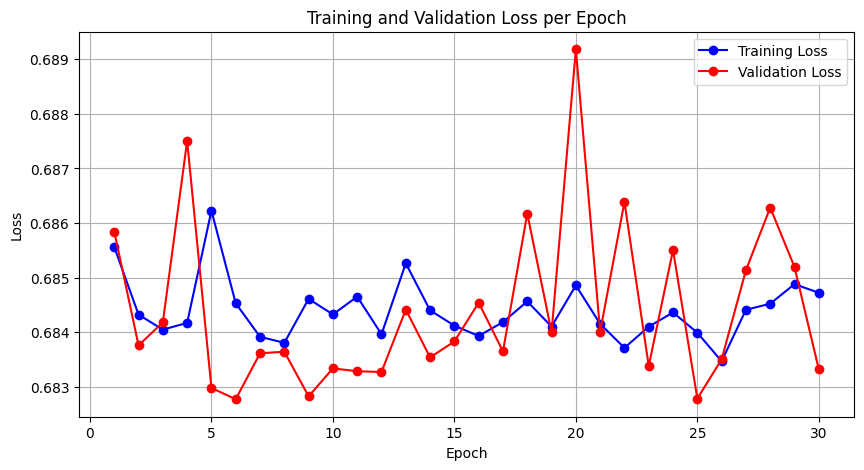

Best Model Training Accuracy: 56.72092632992113%
Best Model Validation Accuracy: 56.8780997128687%


In [61]:
#Training loop
import matplotlib.pyplot as plt
import time
import datetime

# ... 

num_epochs = 30  # Number of epochs
losses = []  # List to store the average train loss per epoch
val_losses = []  # List to store the average validation loss per epoch
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_epoch = 0  # Epoch with the best validation loss
start_time = time.time()  # Record the start time
loop_time = time.time()


for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    total_val_loss = 0
    count = 0
    val_count = 0
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(-1).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count
    losses.append(average_loss)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.unsqueeze(-1).float()
            val_outputs = model(inputs)
            val_outputs = val_outputs.squeeze()
            val_loss = criterion(val_outputs, labels.float())
            total_val_loss += val_loss.item()
            val_count += 1
    average_val_loss = total_val_loss / val_count
    val_losses.append(average_val_loss)
    
    elapsed_time = time.time() - loop_time
    remaining_time = int(elapsed_time * (num_epochs - epoch - 1))
    time_string = str(datetime.timedelta(seconds=remaining_time))    
    loop_time = time.time()  # Reset loop time for the next epoch

    print(f'Epoch {epoch+1:2d}/{num_epochs:2d}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}, Remaining: {time_string}        \r', end='')
    
    # Check if the current validation loss is the lowest; if so, save the model
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'rnn_indexing_best_model.pth')  # Save the best model

print()
print("---")
# Calculate and display total elapsed time
total_elapsed = int(time.time() - start_time)
time_string = str(datetime.timedelta(seconds=total_elapsed))
print(f'Total Training Time: {time_string}')

print(f'Lowest Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch + 1}')

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, 'bo-', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model and calculate accuracy only for that
model.load_state_dict(torch.load('rnn_indexing_best_model.pth'))
train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)
print(f'Best Model Training Accuracy: {train_accuracy}%')
print(f'Best Model Validation Accuracy: {val_accuracy}%')
